In [1]:
import pandas as pd
import os
import pickle
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Path to the folder containing the data
data_folder = r'C:\Users\Sushmeet Kaur\OneDrive\Desktop\FinAssist\NSE_Data'

# List of companies and their respective file names
file_paths = {
    'BHARTIARTL': os.path.join(data_folder, 'BHARTIARTL', 'BHARTIARTL_historical_data.csv'),
    'EICHERMOT': os.path.join(data_folder, 'EICHERMOT', 'EICHERMOT_historical_data.csv'),
    'HEROMOTOCO': os.path.join(data_folder, 'HEROMOTOCO', 'HEROMOTOCO_historical_data.csv'),
    'MM': os.path.join(data_folder, 'M&M', 'M&M_historical_data.csv'),
    'TATASTEEL': os.path.join(data_folder, 'TATASTEEL', 'TATASTEEL_historical_data.csv')
}

# Loading Excel files into separate dataframes
dfs = {company: pd.read_csv(path) for company, path in file_paths.items()}

# Checking the first few rows of one dataframe to verify
dfs['BHARTIARTL'].head()

,Date,series,OPEN,HIGH,LOW,PREV. CLOSE,ltp,close,vwap,52W H,52W L,VOLUME,VALUE,No of trades
0,05-May-2025,EQ,"1,868.00","1,873.50","1,849.20","1,851.90","1,866.00","1,866.00","1,864.43","1,904.30","1,219.05","35,48,839","6,61,65,47,877.00","1,03,413"
1,02-May-2025,EQ,"1,852.00","1,883.60","1,832.10","1,864.50","1,849.00","1,851.90","1,854.96","1,904.30","1,219.05","55,28,529","10,25,52,09,665.90","1,81,226"
2,30-Apr-2025,EQ,"1,837.00","1,876.90","1,827.00","1,823.80","1,854.80","1,864.50","1,854.65","1,904.30","1,219.05","91,39,821","16,95,11,67,803.70","1,52,336"
3,29-Apr-2025,EQ,"1,823.70","1,847.80","1,817.60","1,821.80","1,827.20","1,823.80","1,829.51","1,904.30","1,219.05","46,84,155","8,56,96,95,123.70","1,53,385"
4,28-Apr-2025,EQ,"1,836.00","1,838.90","1,813.40","1,817.20","1,820.30","1,821.80","1,822.30","1,904.30","1,219.05","33,01,891","6,01,70,36,292.30","1,00,779"


In [2]:
def clean_and_preprocess(df):
    # Step 1: Clean column names
    df.columns = [col.strip().lower().replace(' ', '_').replace('.', '').replace('/', '_') for col in df.columns]
    
    # Step 2: Convert 'date' to datetime
    df['date'] = pd.to_datetime(df['date'], format='%d-%b-%Y')
    
    # Step 3: Remove commas and convert VOLUME, VALUE, NO_OF_TRADES to numeric
    for col in ['volume', 'value', 'no_of_trades']:
        df[col] = df[col].astype(str).str.replace(',', '', regex=False)
        df[col] = pd.to_numeric(df[col], errors='coerce')
    
    # Step 4: Sort by date
    df = df.sort_values('date').reset_index(drop=True)
    
    return df

# Apply preprocessing to all company dataframes
for company in dfs:
    dfs[company] = clean_and_preprocess(dfs[company])

# Now dfs[company] holds the cleaned dataframes


In [3]:
for company, df in dfs.items():
    print(f"\nCompany: {company}")
    print("Date Range:", df['date'].min().date(), "to", df['date'].max().date())
    print("Missing Values:\n", df.isnull().sum())
    print("Data Types:\n", df.dtypes)
    print("First few rows:\n", df.head(2))


Company: BHARTIARTL
Date Range: 2024-05-06 to 2025-05-05
Missing Values:
 date            0
series          0
open            0
high            0
low             0
prev_close      0
ltp             0
close           0
vwap            0
52w_h           0
52w_l           0
volume          0
value           0
no_of_trades    0
dtype: int64
Data Types:
 date            datetime64[ns]
series                  object
open                    object
high                    object
low                     object
prev_close              object
ltp                     object
close                   object
vwap                    object
52w_h                   object
52w_l                   object
volume                   int64
value                  float64
no_of_trades             int64
dtype: object
First few rows:
         date series      open      high       low prev_close       ltp  \
0 2024-05-06     EQ  1,275.00  1,298.45  1,273.20   1,277.40  1,282.75   
1 2024-05-07     EQ  1,286.35  1,2

In [4]:
def preprocess_dataframe(df):
    price_cols = ['open', 'high', 'low', 'prev_close', 'ltp', 'close', 'vwap', '52w_h', '52w_l']
    for col in price_cols:
        df[col] = df[col].str.replace(',', '').astype(float)
    return df

In [5]:
df_bhartiartl = dfs['BHARTIARTL']
df_eichermot = dfs['EICHERMOT']
df_heromotoco = dfs['HEROMOTOCO']
df_mm = dfs['MM']
df_tatasteel = dfs['TATASTEEL']

In [6]:
df_bhartiartl = preprocess_dataframe(df_bhartiartl)
df_eichermot = preprocess_dataframe(df_eichermot)
df_heromotoco = preprocess_dataframe(df_heromotoco)
df_mm = preprocess_dataframe(df_mm)
# df_tatasteel already has float values, no need to preprocess


--- BHARTIARTL ---
Shape: (248, 14)
Data Types:
 date            datetime64[ns]
series                  object
open                   float64
high                   float64
low                    float64
prev_close             float64
ltp                    float64
close                  float64
vwap                   float64
52w_h                  float64
52w_l                  float64
volume                   int64
value                  float64
no_of_trades             int64
dtype: object
Missing Values:
 date            0
series          0
open            0
high            0
low             0
prev_close      0
ltp             0
close           0
vwap            0
52w_h           0
52w_l           0
volume          0
value           0
no_of_trades    0
dtype: int64


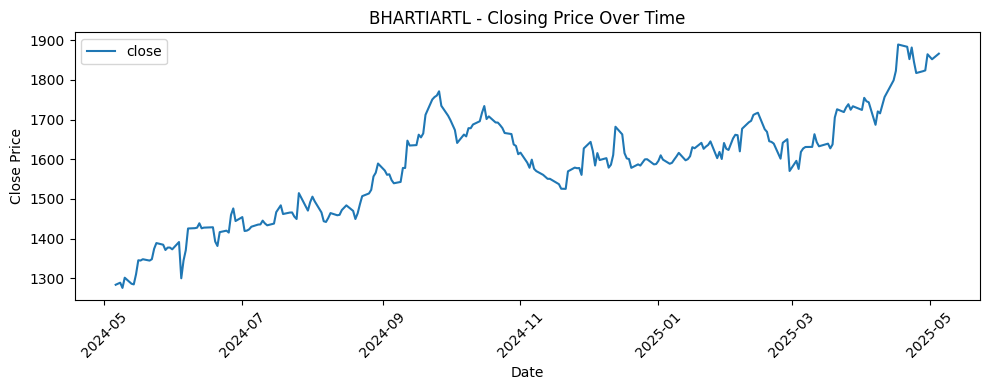

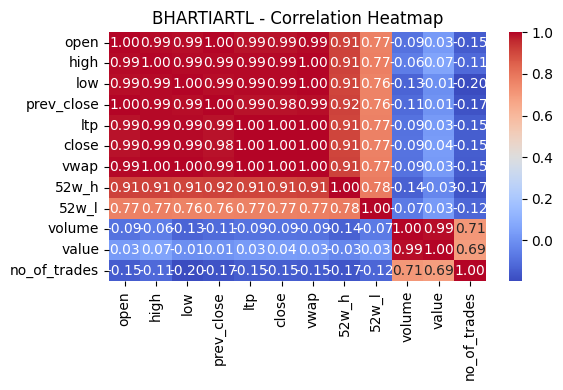


--- EICHERMOT ---
Shape: (248, 14)
Data Types:
 date            datetime64[ns]
series                  object
open                   float64
high                   float64
low                    float64
prev_close             float64
ltp                    float64
close                  float64
vwap                   float64
52w_h                  float64
52w_l                  float64
volume                   int64
value                  float64
no_of_trades             int64
dtype: object
Missing Values:
 date            0
series          0
open            0
high            0
low             0
prev_close      0
ltp             0
close           0
vwap            0
52w_h           0
52w_l           0
volume          0
value           0
no_of_trades    0
dtype: int64


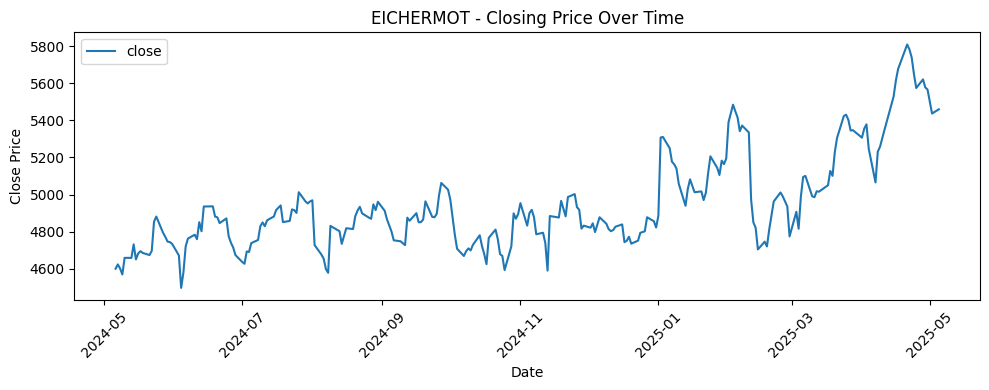

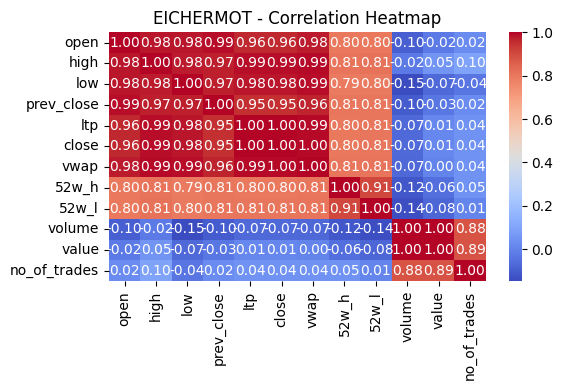


--- HEROMOTOCO ---
Shape: (248, 14)
Data Types:
 date            datetime64[ns]
series                  object
open                   float64
high                   float64
low                    float64
prev_close             float64
ltp                    float64
close                  float64
vwap                   float64
52w_h                  float64
52w_l                  float64
volume                   int64
value                  float64
no_of_trades             int64
dtype: object
Missing Values:
 date            0
series          0
open            0
high            0
low             0
prev_close      0
ltp             0
close           0
vwap            0
52w_h           0
52w_l           0
volume          0
value           0
no_of_trades    0
dtype: int64


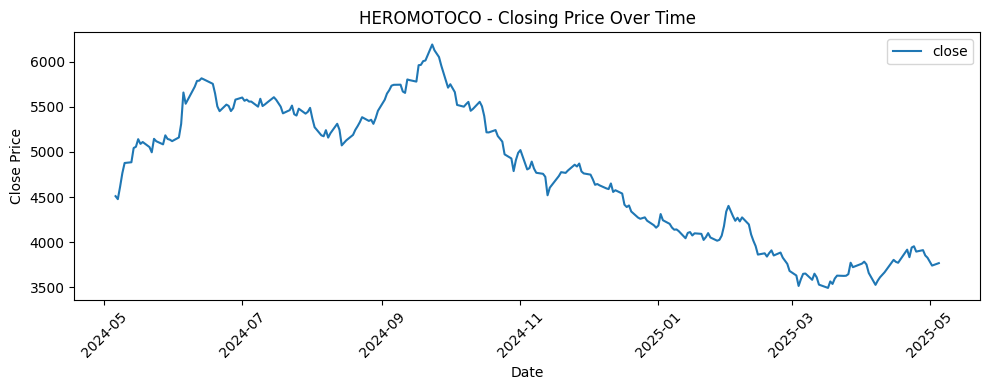

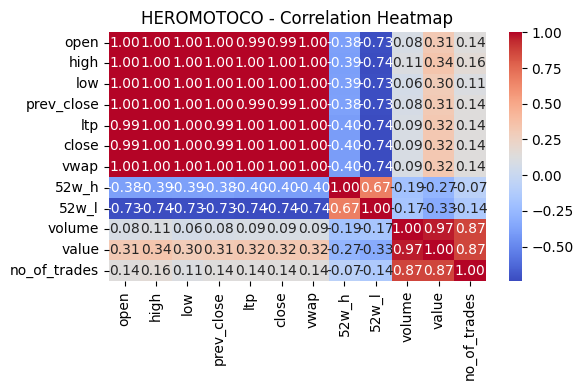


--- MM ---
Shape: (248, 14)
Data Types:
 date            datetime64[ns]
series                  object
open                   float64
high                   float64
low                    float64
prev_close             float64
ltp                    float64
close                  float64
vwap                   float64
52w_h                  float64
52w_l                  float64
volume                   int64
value                  float64
no_of_trades             int64
dtype: object
Missing Values:
 date            0
series          0
open            0
high            0
low             0
prev_close      0
ltp             0
close           0
vwap            0
52w_h           0
52w_l           0
volume          0
value           0
no_of_trades    0
dtype: int64


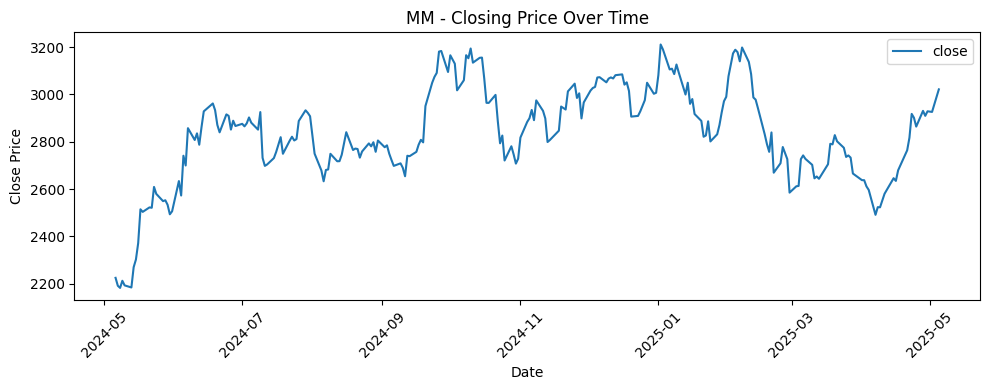

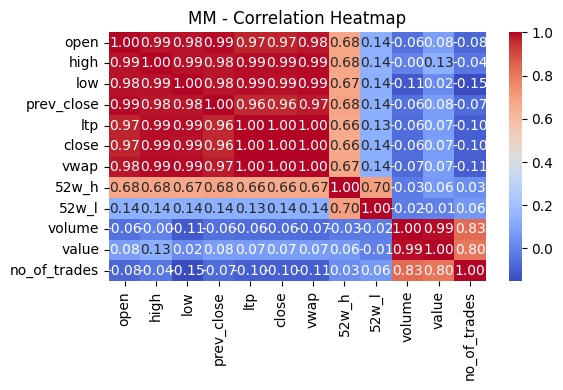


--- TATASTEEL ---
Shape: (248, 14)
Data Types:
 date            datetime64[ns]
series                  object
open                   float64
high                   float64
low                    float64
prev_close             float64
ltp                    float64
close                  float64
vwap                   float64
52w_h                  float64
52w_l                  float64
volume                   int64
value                  float64
no_of_trades             int64
dtype: object
Missing Values:
 date            0
series          0
open            0
high            0
low             0
prev_close      0
ltp             0
close           0
vwap            0
52w_h           0
52w_l           0
volume          0
value           0
no_of_trades    0
dtype: int64


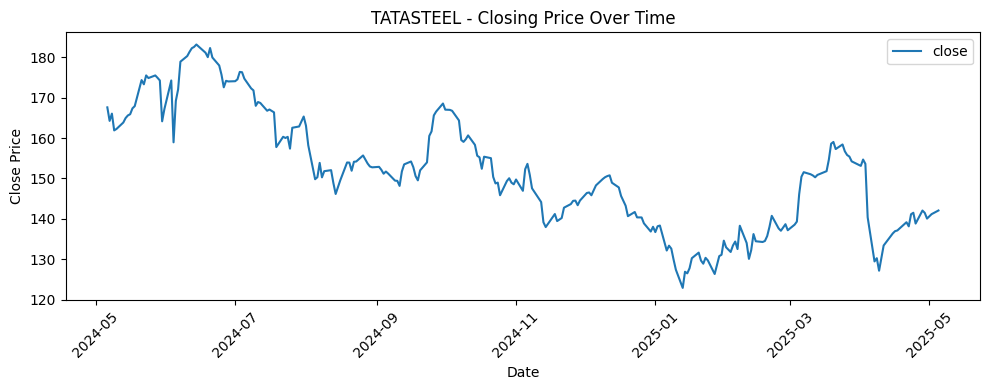

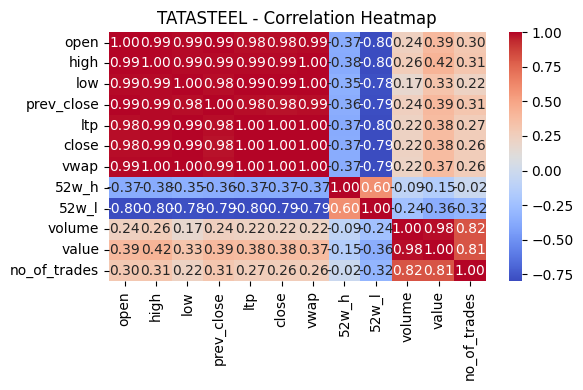

In [7]:
for company, df in dfs.items():
    print(f"\n--- {company} ---")
    print("Shape:", df.shape)
    print("Data Types:\n", df.dtypes)
    print("Missing Values:\n", df.isnull().sum())
    
    # Plot closing price
    plt.figure(figsize=(10, 4))
    plt.plot(df['date'], df['close'], label='close')
    plt.title(f"{company} - Closing Price Over Time")
    plt.xlabel('Date')
    plt.ylabel('Close Price')
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    # Correlation heatmap
    numeric_cols = df.select_dtypes(include='number')
    plt.figure(figsize=(6, 4))
    sns.heatmap(numeric_cols.corr(), annot=True, cmap='coolwarm', fmt='.2f')
    plt.title(f"{company} - Correlation Heatmap")
    plt.tight_layout()
    plt.show()

In [8]:
def create_sequences(df, window_size=30):
    features = ['open', 'high', 'low', 'prev_close', 'ltp', 'close', 'vwap', '52w_h', '52w_l', 'volume', 'value', 'no_of_trades']

    # Convert to numeric and remove commas
    for col in features:
        df[col] = df[col].astype(str).str.replace(',', '').astype(float)

    scaler = MinMaxScaler()
    df_scaled = scaler.fit_transform(df[features])  # scale all selected features

    X, y = [], []
    for i in range(window_size, len(df_scaled)):
        X.append(df_scaled[i - window_size:i])                # 30 timesteps
        y.append(df_scaled[i, features.index('close')])       # predict normalized close price

    X, y = np.array(X), np.array(y)
    return X, y, scaler

company_data = {}
for company, df in dfs.items():
    X, y, scaler = create_sequences(df, window_size=30)
    company_data[company] = {'X': X, 'y': y, 'scaler': scaler}

company_data['BHARTIARTL']['X'].shape, company_data['BHARTIARTL']['y'].shape


((218, 30, 12), (218,))

In [9]:
def split_data(X, y, train_size=0.8, validation_size=0.1, test_size=0.1):
    # First split into train + temp (train + validation)
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, train_size=train_size, shuffle=False)
    
    # Now split the remaining data (temp) into validation and test sets
    validation_size_adjusted = validation_size / (validation_size + test_size)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, train_size=validation_size_adjusted, shuffle=False)
    
    return X_train, X_val, X_test, y_train, y_val, y_test

# Split data for each company
company_splits = {}
for company, data in company_data.items():
    X_train, X_val, X_test, y_train, y_val, y_test = split_data(data['X'], data['y'])
    company_splits[company] = {
        'X_train': X_train, 'X_val': X_val, 'X_test': X_test,
        'y_train': y_train, 'y_val': y_val, 'y_test': y_test,
        'scaler': data['scaler']  # include scaler for inverse transform later
    }

# Check the shapes of the splits for one company
company_splits['BHARTIARTL']['X_train'].shape, company_splits['BHARTIARTL']['X_val'].shape, company_splits['BHARTIARTL']['X_test'].shape

((174, 30, 12), (22, 30, 12), (22, 30, 12))

In [10]:
def build_lstm_model(input_shape):
    model = Sequential()

    # Adding LSTM layers
    model.add(LSTM(units=64, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.2))
    model.add(LSTM(units=64, return_sequences=False))
    model.add(Dropout(0.2))

    # Fully connected layer for output
    model.add(Dense(units=1))

    # Compiling the model
    model.compile(optimizer='adam', loss='mean_squared_error')
    
    # Save the model
    model.save(r"C:\Users\Sushmeet Kaur\Downloads\close_price_prediction_model.h5")
    print("Model successfully saved to downloads folder")

    return model

# Define input shape for LSTM (time steps, features)
# Ensure X_train is properly defined (assuming you have already split your data)
input_shape = (X_train.shape[1], X_train.shape[2])

# Build the LSTM model
lstm_model = build_lstm_model(input_shape)

# Summarize the model
lstm_model.summary()

C:\Users\Sushmeet Kaur\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model successfully saved to downloads folder


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 30, 64)              │          19,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 30, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 64)                  │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 52,801 (206.25 KB)

 Trainable params: 52,801 (206.25 KB)

 Non-trainable params: 0 (0.00 B)

In [11]:
# Train the model
history = lstm_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 135ms/step - loss: 0.2216 - val_loss: 0.0190
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0531 - val_loss: 0.0387
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0250 - val_loss: 0.0489
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0152 - val_loss: 0.0176
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0121 - val_loss: 0.0174
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0113 - val_loss: 0.0272
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0108 - val_loss: 0.0245
Epoch 8/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0126 - val_loss: 0.0167
Epoch 9/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0088 - val_loss: 0.0217
Epoch 10/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0090 - val_loss: 0.0236
Epoch 11/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0118 - val_loss: 0.0173
Epoch 12/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0089 - val_loss: 0.0161


In [12]:

# # Saving the trained Keras model to the Downloads folder (recommended way)
# import os

# # downloads_path = os.path.join(os.path.expanduser("~"), "Downloads", "close_price_prediction_model.h5")
# model.save(r"C:\Users\Sushmeet Kaur\Downloads\close_price_prediction_model.h5")
# print("Model successfully saved to:", downloads_path)

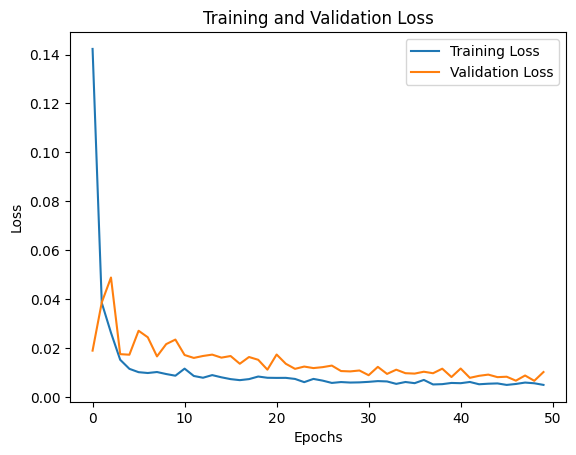

In [13]:
import matplotlib.pyplot as plt

# Plotting the training and validation loss curves
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Epoch 1/50


C:\Users\Sushmeet Kaur\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 73ms/step - loss: 0.1738 - val_loss: 0.0237
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0387 - val_loss: 0.0078
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0119 - val_loss: 0.0258
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0180 - val_loss: 0.0098
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0110 - val_loss: 0.0087
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0102 - val_loss: 0.0074
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0086 - val_loss: 0.0114
Epoch 8/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0078 - val_loss: 0.0077
Epoch 9/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0079 - val_loss: 0.0073
Epoch 10/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0073 - val_loss: 0.0084
Epoch 11/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0058 - val_loss: 0.0078
Epoch 12/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0085 - val_loss: 0.0074
Epoch 13/50


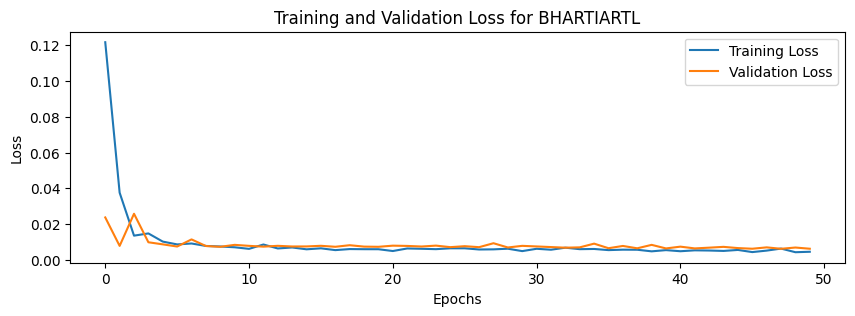

Epoch 1/50


C:\Users\Sushmeet Kaur\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 78ms/step - loss: 0.0663 - val_loss: 0.0245
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0237 - val_loss: 0.0391
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0196 - val_loss: 0.0510
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0180 - val_loss: 0.0238
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0137 - val_loss: 0.0173
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0132 - val_loss: 0.0255
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0141 - val_loss: 0.0293
Epoch 8/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0141 - val_loss: 0.0268
Epoch 9/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0126 - val_loss: 0.0233
Epoch 10/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0129 - val_loss: 0.0208
Epoch 11/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0127 - val_loss: 0.0222
Epoch 12/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0113 - val_loss: 0.0237
Epoch 13/50


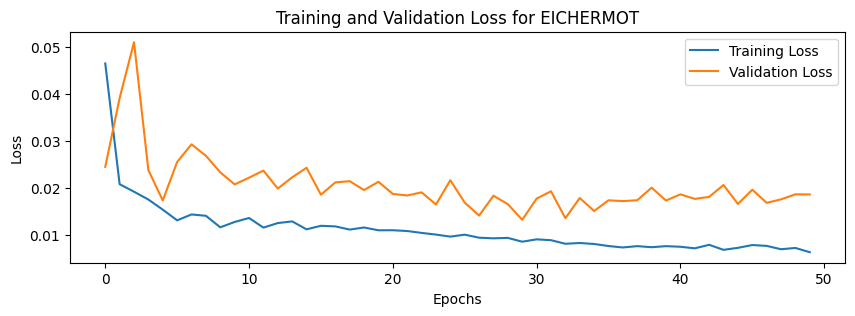

Epoch 1/50


C:\Users\Sushmeet Kaur\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 147ms/step - loss: 0.2611 - val_loss: 0.0289
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0350 - val_loss: 0.0224
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0143 - val_loss: 0.0098
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0179 - val_loss: 0.0183
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0125 - val_loss: 0.0187
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0101 - val_loss: 0.0100
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0105 - val_loss: 0.0101
Epoch 8/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0083 - val_loss: 0.0085
Epoch 9/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0075 - val_loss: 0.0050
Epoch 10/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0076 - val_loss: 0.0054
Epoch 11/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0073 - val_loss: 0.0038
Epoch 12/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0097 - val_loss: 0.0035
Epoch 13/50

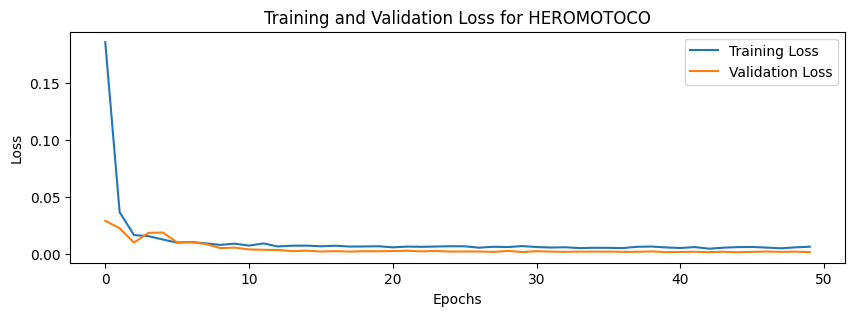

Epoch 1/50


C:\Users\Sushmeet Kaur\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 82ms/step - loss: 0.5038 - val_loss: 0.0126
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0516 - val_loss: 0.0742
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0346 - val_loss: 0.0094
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0359 - val_loss: 0.0090
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0212 - val_loss: 0.0245
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0306 - val_loss: 0.0247
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0169 - val_loss: 0.0098
Epoch 8/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0217 - val_loss: 0.0115
Epoch 9/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0214 - val_loss: 0.0180
Epoch 10/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0199 - val_loss: 0.0162
Epoch 11/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0230 - val_loss: 0.0148
Epoch 12/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0168 - val_loss: 0.0145
Epoch 13/50


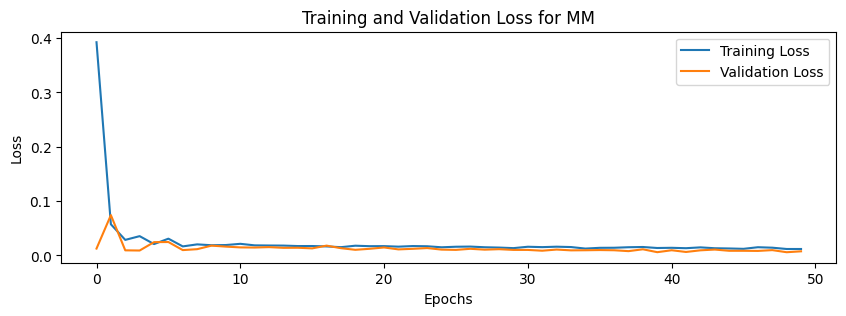

Epoch 1/50


C:\Users\Sushmeet Kaur\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 107ms/step - loss: 0.2173 - val_loss: 0.0241
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0262 - val_loss: 0.0157
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0158 - val_loss: 0.0394
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0211 - val_loss: 0.0211
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0131 - val_loss: 0.0090
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0174 - val_loss: 0.0186
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0126 - val_loss: 0.0224
Epoch 8/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0108 - val_loss: 0.0174
Epoch 9/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0104 - val_loss: 0.0193
Epoch 10/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0122 - val_loss: 0.0240
Epoch 11/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0108 - val_loss: 0.0223
Epoch 12/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0104 - val_loss: 0.0186
Epoch 13/50

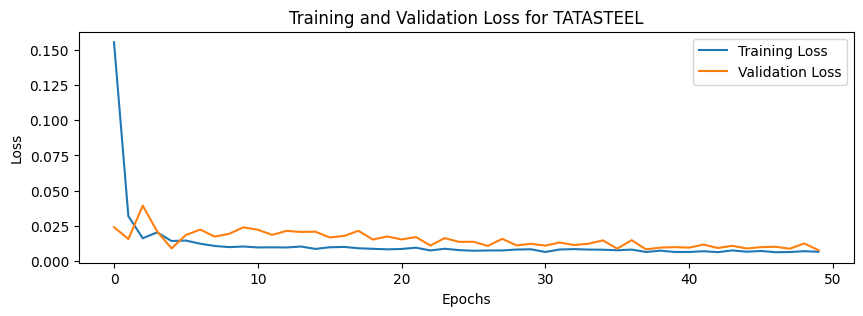

In [14]:
# Function to normalize data and create sequences
def create_sequences(df, window_size=30):
    scaler = MinMaxScaler(feature_range=(0, 1))
    df_scaled = scaler.fit_transform(df[['close']])  # Normalize only the 'close' column
    
    # Creating the sequences
    X = []
    y = []
    
    for i in range(window_size, len(df_scaled)):
        X.append(df_scaled[i-window_size:i, 0])  # Sequence of 30 days (window_size)
        y.append(df_scaled[i, 0])  # The next day's closing price
    
    # Convert to numpy arrays
    X, y = np.array(X), np.array(y)
    
    # Reshape X for LSTM [samples, time steps, features]
    X = np.reshape(X, (X.shape[0], X.shape[1], 1))
    
    return X, y, scaler

# Function to split data into training, validation, and test sets
def split_data(X, y, train_size=0.8, validation_size=0.1, test_size=0.1):
    # First split into train + temp (train + validation)
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, train_size=train_size, shuffle=False)
    
    # Now split the remaining data (temp) into validation and test sets
    validation_size_adjusted = validation_size / (validation_size + test_size)  # Adjust the ratio for validation and test
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, train_size=validation_size_adjusted, shuffle=False)
    
    return X_train, X_val, X_test, y_train, y_val, y_test

# Function to build the LSTM model
def build_lstm_model(input_shape):
    model = Sequential()

    # Adding LSTM layers
    model.add(LSTM(units=64, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.2))
    model.add(LSTM(units=64, return_sequences=False))
    model.add(Dropout(0.2))

    # Fully connected layer for output
    model.add(Dense(units=1))

    # Compiling the model
    model.compile(optimizer='adam', loss='mean_squared_error')
    

    return model

# Create sequences for each company and train separate models
company_data = {}
company_models = {}

for company, df in dfs.items():  # Assuming 'dfs' is the dictionary containing dataframes for each company
    X, y, scaler = create_sequences(df, window_size=30)
    company_data[company] = {'X': X, 'y': y, 'scaler': scaler}
    
    # Split the data into training, validation, and test sets
    X_train, X_val, X_test, y_train, y_val, y_test = split_data(X, y)
    
    # Define input shape for LSTM (samples, time steps, features)
    input_shape = (X_train.shape[1], X_train.shape[2])

    # Build the LSTM model
    lstm_model = build_lstm_model(input_shape)
    
    # Train the model
    history = lstm_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val))
    
    # Save the trained model for each company
    company_models[company] = lstm_model
    
    # Plotting the training and validation loss curves for each company
    plt.figure(figsize=(10, 3))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'Training and Validation Loss for {company}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# Now 'company_models' contains the LSTM model for each company


Epoch 1/50


C:\Users\Sushmeet Kaur\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - loss: 0.1633 - val_loss: 0.0276
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0333 - val_loss: 0.0092
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0137 - val_loss: 0.0298
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0166 - val_loss: 0.0072
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0093 - val_loss: 0.0098
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0090 - val_loss: 0.0084
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0073 - val_loss: 0.0100
Epoch 8/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0080 - val_loss: 0.0074
Epoch 9/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0057 - val_loss: 0.0073
Epoch 10/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0064 - val_loss: 0.0076
Epoch 11/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0073 - val_loss: 0.0088
Epoch 12/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0060 - val_loss: 0.0071
Epoch 13/50


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


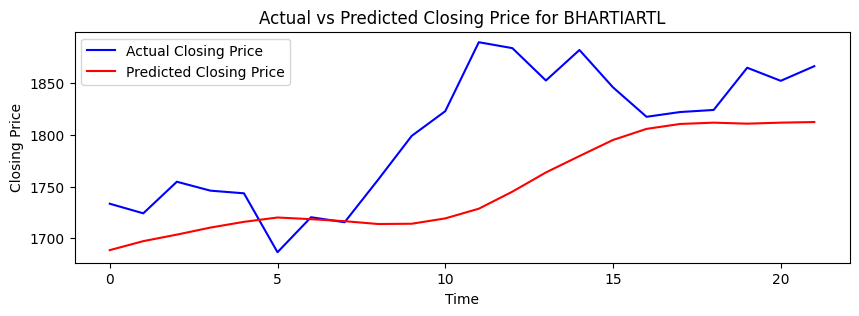

Epoch 1/50


C:\Users\Sushmeet Kaur\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - loss: 0.0467 - val_loss: 0.0195
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0199 - val_loss: 0.0407
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0168 - val_loss: 0.0337
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0142 - val_loss: 0.0198
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0141 - val_loss: 0.0259
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0150 - val_loss: 0.0278
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0139 - val_loss: 0.0244
Epoch 8/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0132 - val_loss: 0.0230
Epoch 9/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0148 - val_loss: 0.0285
Epoch 10/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0151 - val_loss: 0.0242
Epoch 11/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0115 - val_loss: 0.0218
Epoch 12/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0125 - val_loss: 0.0250
Epoch 13/50


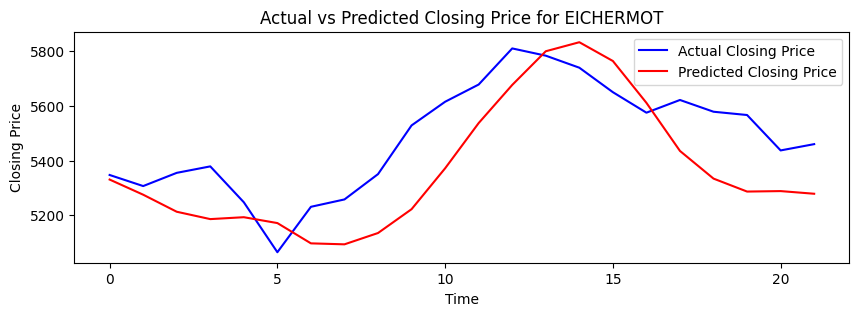

Epoch 1/50


C:\Users\Sushmeet Kaur\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step - loss: 0.2266 - val_loss: 0.0447
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0478 - val_loss: 0.0137
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0172 - val_loss: 0.0096
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0167 - val_loss: 0.0197
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0141 - val_loss: 0.0168
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0105 - val_loss: 0.0085
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0118 - val_loss: 0.0083
Epoch 8/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0095 - val_loss: 0.0088
Epoch 9/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0088 - val_loss: 0.0044
Epoch 10/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0125 - val_loss: 0.0053
Epoch 11/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0086 - val_loss: 0.0038
Epoch 12/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0081 - val_loss: 0.0036
Epoch 13/50


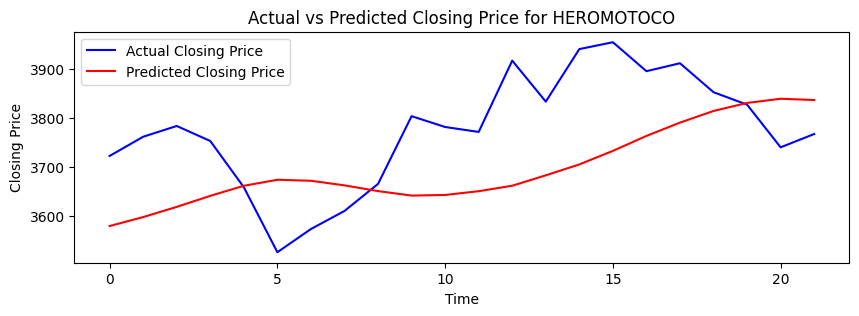

Epoch 1/50


C:\Users\Sushmeet Kaur\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - loss: 0.3954 - val_loss: 0.0188
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0555 - val_loss: 0.0373
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0245 - val_loss: 0.0090
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0308 - val_loss: 0.0150
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0214 - val_loss: 0.0414
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0270 - val_loss: 0.0160
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0198 - val_loss: 0.0155
Epoch 8/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0208 - val_loss: 0.0262
Epoch 9/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0219 - val_loss: 0.0176
Epoch 10/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0193 - val_loss: 0.0151
Epoch 11/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0175 - val_loss: 0.0213
Epoch 12/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0205 - val_loss: 0.0170
Epoch 13/50


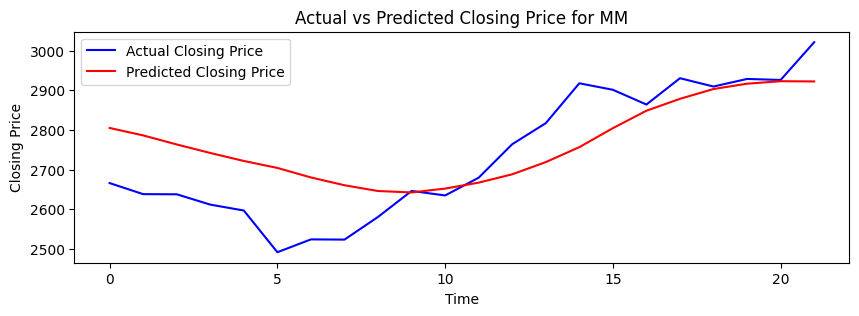

Epoch 1/50


C:\Users\Sushmeet Kaur\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - loss: 0.1840 - val_loss: 0.0198
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0298 - val_loss: 0.0154
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0145 - val_loss: 0.0356
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0246 - val_loss: 0.0178
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0144 - val_loss: 0.0080
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0131 - val_loss: 0.0144
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0093 - val_loss: 0.0167
Epoch 8/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0092 - val_loss: 0.0126
Epoch 9/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0080 - val_loss: 0.0170
Epoch 10/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0087 - val_loss: 0.0183
Epoch 11/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0103 - val_loss: 0.0139
Epoch 12/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0080 - val_loss: 0.0174
Epoch 13/50


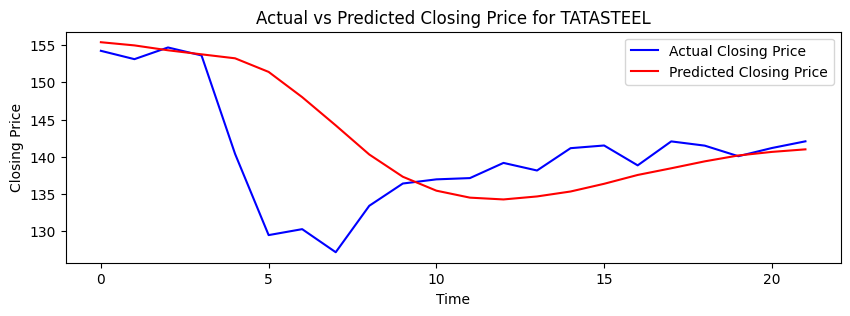

In [45]:
# Function to plot actual vs predicted closing prices
def plot_actual_vs_predicted(company, y_test, predicted_prices):
    plt.figure(figsize=(10, 3))
    plt.plot(y_test, color='blue', label='Actual Closing Price')
    plt.plot(predicted_prices, color='red', label='Predicted Closing Price')
    plt.title(f'Actual vs Predicted Closing Price for {company}')
    plt.xlabel('Time')
    plt.ylabel('Closing Price')
    plt.legend()
    plt.show()

# Create sequences for each company and train separate models
company_data = {}
company_models = {}

for company, df in dfs.items():  # Assuming 'dfs' is the dictionary containing dataframes for each company
    X, y, scaler = create_sequences(df, window_size=30)
    company_data[company] = {'X': X, 'y': y, 'scaler': scaler}
    
    # Split the data into training, validation, and test sets
    X_train, X_val, X_test, y_train, y_val, y_test = split_data(X, y)
    
    # Define input shape for LSTM (samples, time steps, features)
    input_shape = (X_train.shape[1], X_train.shape[2])

    # Build the LSTM model
    lstm_model = build_lstm_model(input_shape)
    
    # Train the model
    history = lstm_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val))
    
    # Save the trained model for each company
    company_models[company] = lstm_model
    
    # Predict on the test set
    predicted_prices = lstm_model.predict(X_test)
    
    # Inverse transform the predicted prices and the actual test prices to their original scale
    predicted_prices = scaler.inverse_transform(predicted_prices)
    y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))  # Reshape y_test to 2D for inverse transformation
    
    # Plot the actual vs predicted closing prices
    plot_actual_vs_predicted(company, y_test_actual, predicted_prices)

# Now 'company_models' contains the LSTM model for each company, and you have actual vs predicted plots


In [19]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import math

# Dictionary to store model performance for each company
model_performance = {}

for company, model in company_models.items():
    data = company_data[company]
    X, y, scaler = data['X'], data['y'], data['scaler']
    
    # Re-split the data to get test set
    X_train, X_val, X_test, y_train, y_val, y_test = split_data(X, y)
    
    # Predict on test set
    predicted = model.predict(X_test)
    
    # Inverse transform predictions and actual values
    predicted_prices = scaler.inverse_transform(predicted)
    actual_prices = scaler.inverse_transform(y_test.reshape(-1, 1))
    
    # Calculate evaluation metrics
    mae = mean_absolute_error(actual_prices, predicted_prices)
    mse = mean_squared_error(actual_prices, predicted_prices)
    rmse = math.sqrt(mse)
    r2 = r2_score(actual_prices, predicted_prices)
    
    # Store metrics
    model_performance[company] = {
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse,
        'R2 Score': r2
    }
    
    # Print metrics
    print(f"\nPerformance for {company}:")
    print(f"MAE: {mae:.4f}")
    print(f"MSE: {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"R² Score: {r2:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step

Performance for BHARTIARTL:
MAE: 49.0959
MSE: 4049.7238
RMSE: 63.6374
R² Score: -0.0362
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step

Performance for EICHERMOT:
MAE: 161.2832
MSE: 32294.9461
RMSE: 179.7079
R² Score: 0.1479
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step

Performance for HEROMOTOCO:
MAE: 119.8571
MSE: 18981.9185
RMSE: 137.7749
R² Score: -0.4659
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step

Performance for MM:
MAE: 100.4979
MSE: 14474.4565
RMSE: 120.3098
R² Score: 0.4338


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step

Performance for TATASTEEL:
MAE: 5.5169
MSE: 75.4803
RMSE: 8.6879
R² Score: -0.3464


In [21]:
# Save the trained model for each company
company_models[company] = lstm_model

In [22]:
# Save the trained model for each company
company_models[company] = lstm_model
lstm_model.save(f"{company}_model.h5")
print(f"Saved model for {company} as {company}_model.h5")

Saved model for TATASTEEL as TATASTEEL_model.h5
